<a href="https://colab.research.google.com/github/pgordin/GraphsSN2025/blob/main/Approx_TSP_Project_Veselovska.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Approximate Solutions to the Traveling Salesman Problem (TSP)

## Project goal
The goal of this project is to implement and demonstrate **approximation / heuristic algorithms** for the Traveling Salesman Problem (TSP).  



## Relation to other graph problems

The Traveling Salesman Problem is closely related to other graph problems studied in this course.

An **Eulerian tour** focuses on finding a cycle that traverses all edges of a graph exactly once, while TSP searches for a cycle that visits all vertices exactly once.  
Although the constraints are different, both problems deal with finding valid cycles in graphs.

Similarly, the **Maximum Flow problem** and TSP are both optimization problems on graphs.  
Maximum Flow optimizes the amount of flow under capacity constraints, while TSP optimizes the total length of a tour under visit constraints.

These connections place the Traveling Salesman Problem within the broader context of graph theory and network optimization.
he connection is conceptual rather than algorithmic.

In this project, I focus on heuristic methods for TSP, but the understanding of cycles, constraints, and optimization comes directly from graph theory topics such as Eulerian tours and flow problems

## I focus on practical approaches that quickly produce good (not necessarily optimal) tours:
- **Nearest Neighbor** (fast constructive heuristic)
- **Cheapest Insertion** (constructive heuristic with better quality in many cases)
- **2-opt** (local search improvement)

## Short description of Idea

1) TSP asks for the shortest tour visiting all cities once. It is NP-hard, so we use heuristics to get good solutions quickly.

2) I implemented two constructive heuristics: Nearest Neighbor and Cheapest Insertion.  
Nearest Neighbor is greedy: always go to the closest unvisited city.  
Cheapest Insertion keeps a cycle and inserts each new city where it increases length the least.

3) Then I use 2-opt local search. It tries to improve the tour by swapping two edges.  
In Euclidean instances, removing crossings typically reduces length, so 2-opt is very effective.

4) I demonstrate a step-by-step example for a small number of cities and show how 2-opt improves the initial greedy tour.  
Finally, I compare methods on larger random instances and visualize the best tour.


In [1]:
import math
import random
from dataclasses import dataclass
from typing import List, Tuple

import numpy as np
import matplotlib.pyplot as plt


## Problem definition (TSP)
Given `n` cities and distances between every pair, we want a **shortest possible closed tour**
that visits each city exactly once and returns to the start.

TSP is **NP-hard**, so for larger `n` we usually use **approximation / heuristics**:
they are fast and produce good solutions, but not guaranteed optimal.


In [2]:
def euclidean_distance(a: np.ndarray, b: np.ndarray) -> float:
    return float(np.linalg.norm(a - b))

def compute_distance_matrix(points: np.ndarray) -> np.ndarray:
    n = len(points)
    D = np.zeros((n, n), dtype=float)
    for i in range(n):
        for j in range(i+1, n):
            d = euclidean_distance(points[i], points[j])
            D[i, j] = D[j, i] = d
    return D

def tour_length(tour: List[int], D: np.ndarray) -> float:
    total = 0.0
    for i in range(len(tour)):
        total += D[tour[i], tour[(i+1) % len(tour)]]
    return total


In [3]:
def plot_tour(points: np.ndarray, tour: List[int], title: str = ""):
    pts = points[tour + [tour[0]]]  # close the cycle
    plt.figure(figsize=(6, 6))
    plt.plot(pts[:, 0], pts[:, 1], marker='o')
    for idx, (x, y) in enumerate(points):
        plt.text(x, y, str(idx), fontsize=9, ha='right', va='bottom')
    plt.title(title)
    plt.axis('equal')
    plt.show()


## Algorithms used (and why this shape makes sense)




### 1) Nearest Neighbor (NN)
**Idea:** start from a city, repeatedly go to the nearest unvisited city.  
**Why it makes sense:** it follows a greedy local rule: “don’t waste distance now”.  
**Pros:** extremely fast, simple, good as a baseline.  
**Cons:** greedy choices can trap us into a bad global tour.



In [4]:
def nearest_neighbor_tour(D: np.ndarray, start: int = 0) -> List[int]:
    n = D.shape[0]
    unvisited = set(range(n))
    tour = [start]
    unvisited.remove(start)

    current = start
    while unvisited:
        nxt = min(unvisited, key=lambda j: D[current, j])
        tour.append(nxt)
        unvisited.remove(nxt)
        current = nxt
    return tour


### 2) Cheapest Insertion (CI)
**Idea:** start from a small cycle, then insert remaining cities where they increase the tour length the least.  
**Why it makes sense:** instead of committing to a long greedy path, we maintain a cycle and place points where they fit best.  
Usually produces better initial tours than NN.



In [5]:
def cheapest_insertion_tour(D: np.ndarray, start: int = 0) -> List[int]:
    n = D.shape[0]
    remaining = set(range(n))
    remaining.remove(start)

    # pick the nearest city to start to form initial 2-cycle
    second = min(remaining, key=lambda j: D[start, j])
    remaining.remove(second)

    tour = [start, second]  # cycle will be implicit

    # add cities one by one: insert where delta is minimal
    while remaining:
        best_city = None
        best_pos = None
        best_delta = float('inf')

        for c in remaining:
            # try inserting c between tour[i] and tour[i+1]
            for i in range(len(tour)):
                a = tour[i]
                b = tour[(i+1) % len(tour)]
                delta = D[a, c] + D[c, b] - D[a, b]
                if delta < best_delta:
                    best_delta = delta
                    best_city = c
                    best_pos = i + 1

        tour.insert(best_pos, best_city)
        remaining.remove(best_city)

    return tour


### 3) 2-opt improvement
**Idea:** while there are two edges that cross (or are inefficient), remove them and reconnect in the other way.  
**Why it makes sense:** many bad tours have crossings; removing crossings almost always shortens Euclidean tours.  
This is a classic local search: it improves a tour step-by-step until no local 2-edge swap helps.

In [6]:
def two_opt(tour: List[int], D: np.ndarray, max_iters: int = 10_000) -> List[int]:
    n = len(tour)
    best = tour[:]
    best_len = tour_length(best, D)

    improved = True
    iters = 0

    while improved and iters < max_iters:
        improved = False
        iters += 1

        for i in range(n - 1):
            for k in range(i + 2, n if i > 0 else n - 1):
                # edges: (i, i+1) and (k, k+1)
                a, b = best[i], best[(i + 1) % n]
                c, d = best[k], best[(k + 1) % n]

                # current vs swapped cost
                current = D[a, b] + D[c, d]
                swapped = D[a, c] + D[b, d]

                if swapped + 1e-12 < current:
                    # reverse segment (i+1 ... k)
                    best[i+1:k+1] = reversed(best[i+1:k+1])
                    best_len = best_len - current + swapped
                    improved = True

    return best


## Explained example of operation (step-by-step)
Below we will:
1) Generate a small set of cities  
2) Show step-by-step how **Nearest Neighbor** builds a tour  


Nearest Neighbor steps:
0 -> 6   (distance = 0.2437)
6 -> 1   (distance = 0.2452)
1 -> 7   (distance = 0.5201)
7 -> 2   (distance = 0.0314)
2 -> 5   (distance = 0.4564)
5 -> 3   (distance = 0.1488)
3 -> 4   (distance = 0.4722)

NN tour: [0, 6, 1, 7, 2, 5, 3, 4]
NN tour length: 3.0413868970767486


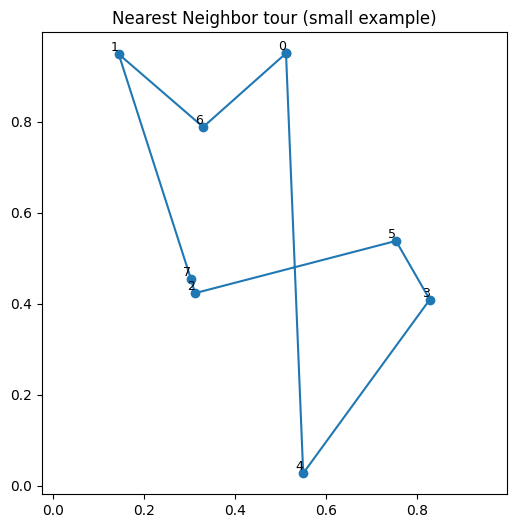

In [7]:
def generate_points(n: int, seed: int = 0) -> np.ndarray:
    rng = np.random.default_rng(seed)
    return rng.random((n, 2))

def nearest_neighbor_trace(D: np.ndarray, start: int = 0) -> List[Tuple[int, int, float]]:
    """
    Returns a list of steps: (from_city, chosen_city, distance)
    """
    n = D.shape[0]
    unvisited = set(range(n))
    unvisited.remove(start)
    current = start
    steps = []

    while unvisited:
        nxt = min(unvisited, key=lambda j: D[current, j])
        steps.append((current, nxt, D[current, nxt]))
        unvisited.remove(nxt)
        current = nxt

    return steps

# Small demo
points_small = generate_points(8, seed=1)
D_small = compute_distance_matrix(points_small)

steps = nearest_neighbor_trace(D_small, start=0)
tour_nn = [0] + [s[1] for s in steps]

print("Nearest Neighbor steps:")
for (a, b, dist) in steps:
    print(f"{a} -> {b}   (distance = {dist:.4f})")

print("\nNN tour:", tour_nn)
print("NN tour length:", tour_length(tour_nn, D_small))

plot_tour(points_small, tour_nn, title="Nearest Neighbor tour (small example)")


3) Improve the tour using **2-opt** and show what changed

The first tour is greedy and rough, the second one is shorter and cleaner.

After 2-opt:
Tour: [0, 1, 6, 7, 2, 4, 3, 5]
Length: 2.540816236279214


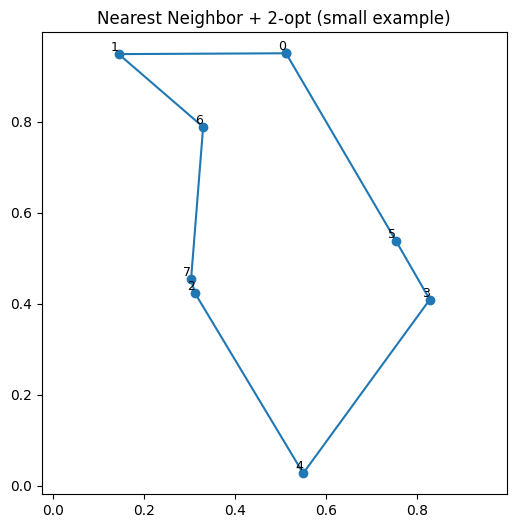

In [8]:
tour_nn_2opt = two_opt(tour_nn, D_small)

print("After 2-opt:")
print("Tour:", tour_nn_2opt)
print("Length:", tour_length(tour_nn_2opt, D_small))

plot_tour(points_small, tour_nn_2opt, title="Nearest Neighbor + 2-opt (small example)")


## Main experiment: compare heuristics on larger instances
We generate `n` random cities in the plane and compare:
- Nearest Neighbor
- Cheapest Insertion
- Each of them + 2-opt improvement




Results (sorted by tour length):
NN + 2-opt          length = 6.5108
CI + 2-opt          length = 7.5624
Nearest Neighbor    length = 7.6038
Cheapest Insertion  length = 7.6936


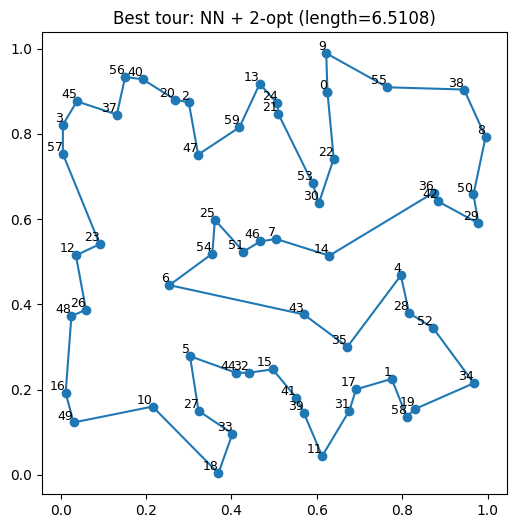

In [9]:
@dataclass
class Result:
    name: str
    tour: List[int]
    length: float

def run_all(points: np.ndarray, start: int = 0) -> List[Result]:
    D = compute_distance_matrix(points)

    nn = nearest_neighbor_tour(D, start=start)
    ci = cheapest_insertion_tour(D, start=start)

    nn2 = two_opt(nn, D)
    ci2 = two_opt(ci, D)

    results = [
        Result("Nearest Neighbor", nn, tour_length(nn, D)),
        Result("Cheapest Insertion", ci, tour_length(ci, D)),
        Result("NN + 2-opt", nn2, tour_length(nn2, D)),
        Result("CI + 2-opt", ci2, tour_length(ci2, D)),
    ]
    results.sort(key=lambda r: r.length)
    return results

# Choose instance size here
n = 60
seed = 7
points = generate_points(n, seed=seed)

results = run_all(points, start=0)

print("Results (sorted by tour length):")
for r in results:
    print(f"{r.name:18s}  length = {r.length:.4f}")

best = results[0]
D = compute_distance_matrix(points)
plot_tour(points, best.tour, title=f"Best tour: {best.name} (length={best.length:.4f})")


We report tour lengths and visualize the best found tour.

**Conclusion:**  
The implemented methods are fast and practical.  
They produce good routes without excessive computation, which is sufficient for real-world use.


## Complexity and justification

Let `n` be the number of cities.

- **Nearest Neighbor:**  
  The algorithm repeatedly chooses the closest unvisited city.  
  When the number of cities increases, the running time increases relatively fast, but it is still manageable for practical use.

- **Cheapest Insertion:**  
  Each new city is inserted into the current tour at the best position.  
  This requires checking many possible places, so the running time also increases noticeably as the number of cities grows.

- **2-opt:**  
  The algorithm improves an existing tour by swapping connections between cities.  
  It checks many local changes, but in practice it usually finishes quickly.

**Reason for the pipeline shape:**  
First, a simple heuristic is used to quickly build a valid tour.  
Then, 2-opt is applied to improve the route by removing inefficient connections.  
This approach produces good solutions without excessive computation.

